In [12]:
# 구글 드라이브 마운트 명령어
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
path = r'/content/drive/MyDrive/hs/2. ExampleData/dm_kaggle_mercari_price_data/data/mercari-price-suggestion-challenge'

## Mercari Price Suggestion Challenge

- 일본 최대의 커뮤니티 기반 쇼핑 앱인 Mercari
- 제품 카테고리명, 브랜드명, 품목상태 등 제품에 대한 구매자의 의견에 대한 텍스트를 제공받아서 적합한 가격을 제공하는 알고리즘을 개발하는 것이 목표



##### Evaluation : RMSLE (Root Mean Squared Logarithmic Error, 평균제곱근로그오차)

In [14]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

In [15]:
mercari_df= pd.read_csv(path + '/train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [16]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


#### 데이터 전처리 (Data Preprocessing)
- target 값인 price 에 대한 분포 확인
- 한쪽으로 치우치 그래프이므로, 변환의 과정을 거치는 것이 필요한가?

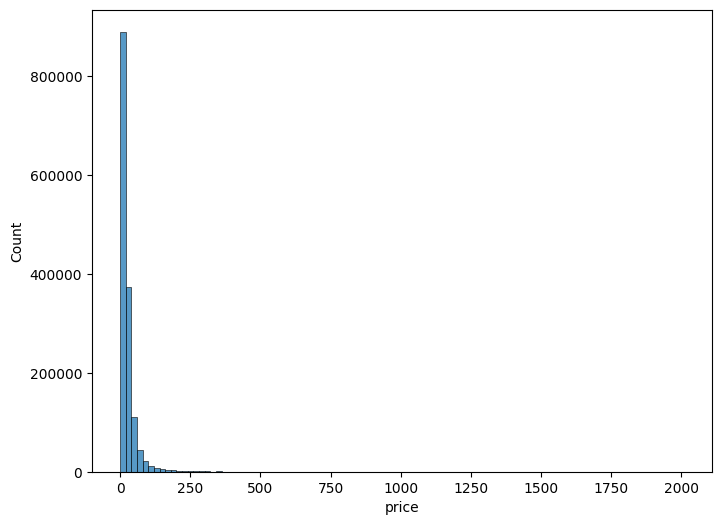

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(8,6))
sns.histplot(y_train_df, bins=100)
plt.show()

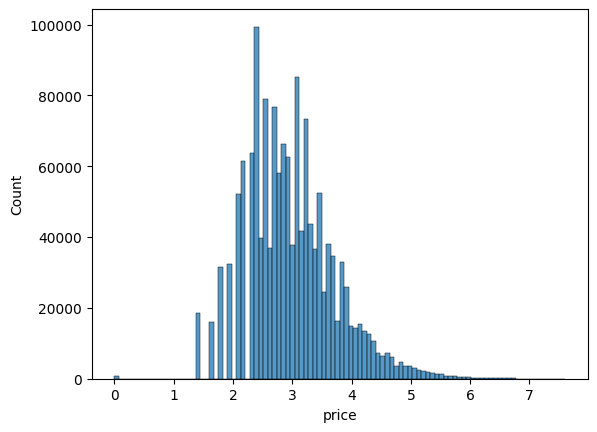

In [18]:
import numpy as np
y_train_df = np.log1p(mercari_df['price'])
sns.histplot(y_train_df, bins=100)
plt.show()

In [19]:
mercari_df['price'] = y_train_df
mercari_df['price'].head(5)

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [26]:
print('Shopping 값 유형 : \n', mercari_df['shipping'].value_counts())
print('item condition_id 값 유형 : \n', mercari_df['item_condition_id'].value_counts())

Shopping 값 유형 : 
 0    819435
1    663100
Name: shipping, dtype: int64
item condition_id 값 유형 : 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [29]:
boolean_cond=mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [30]:
def split_cat(category_name):
  try:
    return category_name('/')
  except:
    return ['Other_Null','Other_Null','Other_Null']

# zip함수에 *args를 인수로 넣을 수 있다.
# 리스트를 그냥 입력하지 말고, *를 붙여서 입력하면 col끼리 서로 엮어준다.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Other_Null    1482535
Name: cat_dae, dtype: int64
중분류 갯수 : 1
소분류 갯수 : 1


In [31]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

In [32]:
# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

#### 피처 인코딩과 피처 벡터화


In [34]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].unique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].head(5) )

brand name 의 유형 건수 : ['Other_Null' 'Razer' 'Target' ... 'Astroglide' 'Cumberland Bay'
 'Kids Only']
brand name sample 5건 : 
 0    Other_Null
1         Razer
2        Target
3    Other_Null
4    Other_Null
Name: brand_name, dtype: object


In [35]:
print('name의 종류 갯수 :', mercari_df['name'].unique())
print('name sample 5건 \n', mercari_df['name'].head(5))

name의 종류 갯수 : ['MLB Cincinnati Reds T Shirt Size XL' 'Razer BlackWidow Chroma Keyboard'
 'AVA-VIV Blouse' ... '21 day fix containers and eating plan'
 'World markets lanterns' 'Brand new lux de ville wallet']
name sample 5건 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
Name: name, dtype: object


In [38]:
pd.set_option('max_colwidth', 200)

print('item_description 평균 문자열 개수 :', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 개수 : 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [44]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
## df.column : 해당 열에 대한 정보를 배열로 출력해준다.
x_name = cnt_vec.fit_transform(mercari_df.name)
# x_name = cnt_vec.fit_transform(mercari_df['name'])

In [49]:
## ndarray에서 일부만 출력 했는데 왜 이렇게 나오는거지?
print(x_name[:1])

  (0, 64986)	1
  (0, 23722)	1
  (0, 79003)	1
  (0, 85748)	1
  (0, 86779)	1
  (0, 103761)	1


In [50]:
print('name vectorization shape:',x_name.shape)

name vectorization shape: (1482535, 105757)


In [51]:
# item_description 에 대한 feature vectorization 변환
tfid_vec = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
# x_descp = tfid_vec.fit_transform(mercari_df['item_description'])
x_descp = tfid_vec.fit_transform(mercari_df.item_description)

In [52]:
print('item_description vectorization shape:',x_descp.shape)

item_description vectorization shape: (1482535, 50000)


In [53]:
mercari_df.column

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'cat_dae', 'cat_jung',
       'cat_so'],
      dtype='object')

In [54]:
from sklearn.preprocessing import LabelBinarizer

lb_brand_name = LabelBinarizer(sparse_output=True)
x_brand = lb_brand_name.fit_transform(mercari_df.brand_name)

lb_item_cond_id = LabelBinarizer(sparse_output=True)
x_item_cond_id = lb_item_cond_id.fit_transform(mercari_df.item_condition_id)

lb_shipping = LabelBinarizer(sparse_output=True)
x_shipping = lb_shipping.fit_transform(mercari_df.shipping)

lb_cat_dae = LabelBinarizer(sparse_output=True)
x_cat_dae = lb_cat_dae.fit_transform(mercari_df.cat_dae)

lb_cat_jung = LabelBinarizer(sparse_output=True)
x_cat_jung = lb_cat_jung.fit_transform(mercari_df.cat_jung)

lb_cat_so = LabelBinarizer(sparse_output=True)
x_cat_so = lb_cat_so.fit_transform(mercari_df.cat_so)



AttributeError: ignored

In [ ]:
from scipy.sparse import hstack
import gc
# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합.
sparse_matrix_list = (x_name, x_descp, x_brand, x_item_cond_id,
                      x_shipping, x_cat_dae, x_cat_jung, x_cat_so)

x_feature_sparse = hstack(sparse_matrix_list).tocsr()
print(type(x_feature_sparse), x_feature_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용용도가 끝났으면 바로 메모리에서 삭제한다.
del x_feature_sparse
gc.collect()